
# The Dirichlet Distribution

The Dirichlet distribution $Dir(\overrightarrow{\alpha})$ is a multivariate generalization of the Beta distribution $\text{Beta}(1.0, \alpha)$.
That is, it the Dirichlet distribution for dimension $K$ is a distribution on the $K-1$ probability simplex.
The Dirichlet distribution is conjugate to the categorical and multinomial distributions.
The parameter vector $\overrightarrow{\alpha}$ determines which of the $K$ dimensions receive more or less probability mass, as well as controlling the overall concentration of the distribution.

Here, we visualize what a Dirichlet distribution looks like for $K=3$ (i.e. on the $\Delta^2$ probability simplex, which is an equilateral triangle embedded in $\mathbb{R}^3$).


In [1]:

%matplotlib inline

import math
import random
import operator
import functools

import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib as mpl
import matplotlib.tri as tri
import matplotlib.pyplot as plt

from scipy.stats import dirichlet


In [2]:

corners = np.array([
    [0, 0],
    [1, 0],
    [0.5, np.sin(np.deg2rad(60))]
])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

def xy2bc(xy, *, tol=1e-3):
    """Convert XY coordinates to barycentric"""
    
    midpoints = np.array([
        (corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0
        for i in range(3)
    ])

    s = [
        (corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75
        for i in range(3)
    ]
    return np.clip(s, tol, 1.0 - tol)


def bc2xy(bc):
    """Convert barycentric coordinates to cartesian"""
    if np.sum(bc) > 0: bc /= np.sum(bc)
    return bc[0] * corners[0] + bc[1] * corners[1] + bc[2] * corners[2]


class Dirichlet():
    
    def __init__(self, alpha):
        self.alpha = np.array(alpha).astype(np.float32)
        # Pre-compute coefficient
        self.coef = (
            math.gamma(np.sum(self.alpha)) /
            np.prod([math.gamma(a) for a in self.alpha])
        )
    
    def pdf(self, theta):
        """The Dirichlet PDF p(θ|α)
        
        Args:
            theta (numpy array): Barycentric parameter vector
        
        Returns:
            (float): PDF of theta given current alpha values
        """
        assert len(theta) == len(self.alpha), "Theta vector must match alpha vector size"
        return self.coef * np.prod([
            ti ** (ai - 1)
            for ti, ai in zip(theta, self.alpha)
        ])


In [3]:

def plot_pdf(dist, nlevels=300, subdiv=7, cmap='afmhot_r', annotate=False, **kwargs):
    """Plot the PDF as a contour
    """
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pdf = [
        dist.pdf(xy2bc(xy))
        for xy in zip(trimesh.x, trimesh.y)
    ]
    
    plt.tricontourf(trimesh, pdf, nlevels, cmap=cmap, **kwargs)
    plt.axis("equal")
    plt.xlim(0, 1)
    plt.ylim(0, 0.75 ** 0.5)
    
    # Draw the simplex boundary
    plt.gca().add_patch(
        mpl.patches.Polygon(corners, closed=True, fill=False, lw=0.1, color='k')
    )
    plt.axis("off")
    plt.title(f"Dir(α = {dist.alpha})", weight='bold', pad=0.0)
    
    if annotate:
        plt.annotate(
            r'$\theta = (1, 0, 0)$',
            (0, 0),
            (-12, -8),
            textcoords='offset points',
            horizontalalignment='center',
            verticalalignment='center'
        )
        plt.annotate(
            r'$\theta = (0, 1, 0)$',
            (1, 0),
            (12, -8),
            textcoords='offset points',
            horizontalalignment='center',
            verticalalignment='center'
        )
        plt.annotate(
            r'$\theta = (0, 0, 1)$',
            (0.5, 0.75 ** 0.5),
            (0, 8),
            textcoords='offset points',
            horizontalalignment='center',
            verticalalignment='center'
        )



C:\Users\uqasnosw\AppData\Local\Continuum\miniconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


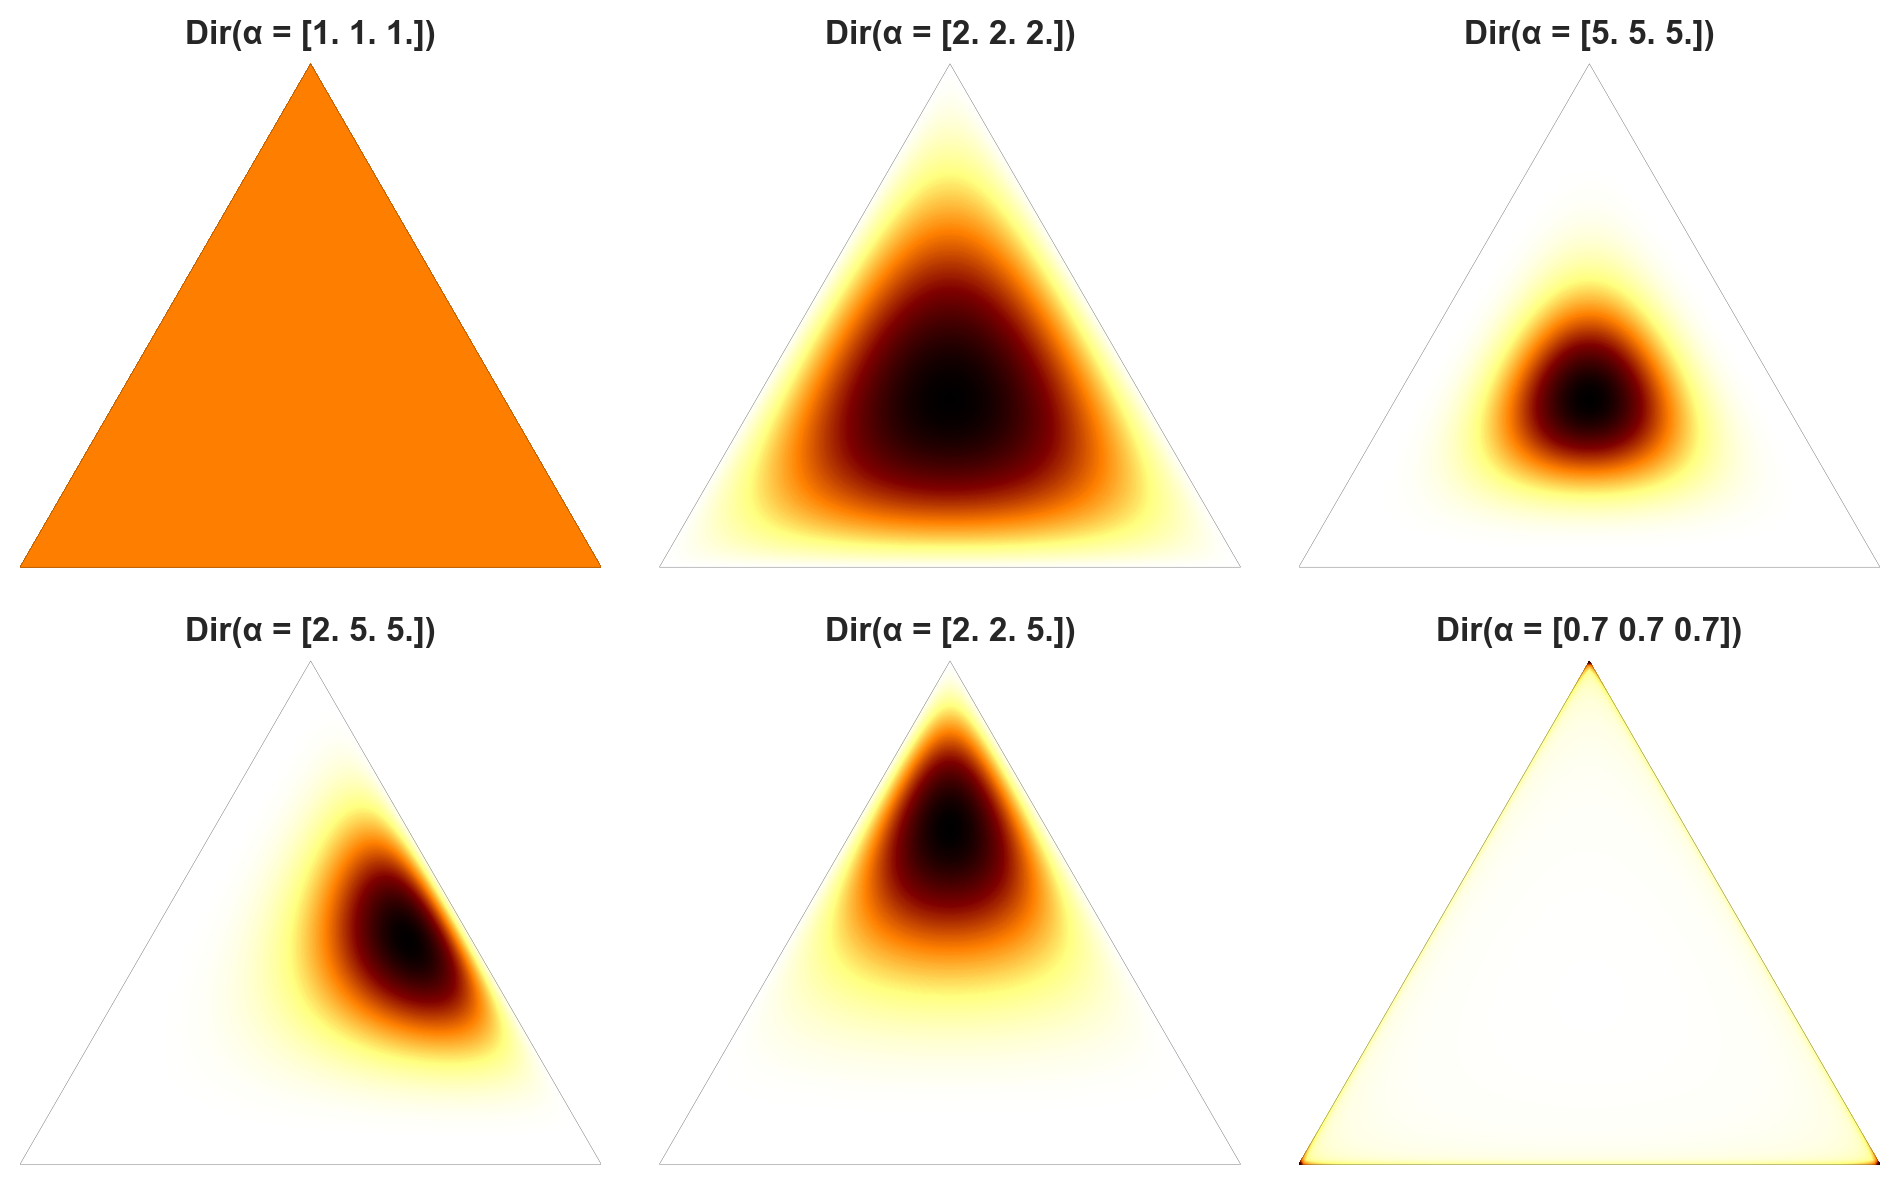

In [4]:

sns.set()
fig, axs = plt.subplots(
    2,
    3,
    figsize=(12, 12),
    dpi=200,
    gridspec_kw=dict(wspace=0.1, hspace=0.1)
)

plt.sca(axs[0, 0])
plot_pdf(Dirichlet([1, 1, 1]))

plt.sca(axs[0, 1])
plot_pdf(Dirichlet([2, 2, 2]))

plt.sca(axs[0, 2])
plot_pdf(Dirichlet([5, 5, 5]))

plt.sca(axs[1, 0])
plot_pdf(Dirichlet([2, 5, 5]))

plt.sca(axs[1, 1])
plot_pdf(Dirichlet([2, 2, 5]))

plt.sca(axs[1, 2])
plot_pdf(Dirichlet([0.7, 0.7, 0.7]))

plt.tight_layout()
plt.subplots_adjust(top=0.6)
plt.show()



## GEM distribution

A special case of the Dirichlet distribution is when the parameter vector $\overrightarrow{\alpha}$ is symmetric, so it can be described by a single real number $\alpha \in (0, \infty)$.
This is known as the GEM distribution after Griffiths, Engen, and McCloskey who first described it.
Often, we write $\text{GEM}(\alpha / K)$ so that the Dirichlet parameter is scaled relative to the parameter $K$.

Visualizing this distribution reveals that for large $\alpha$, we recover the uniform distribution.


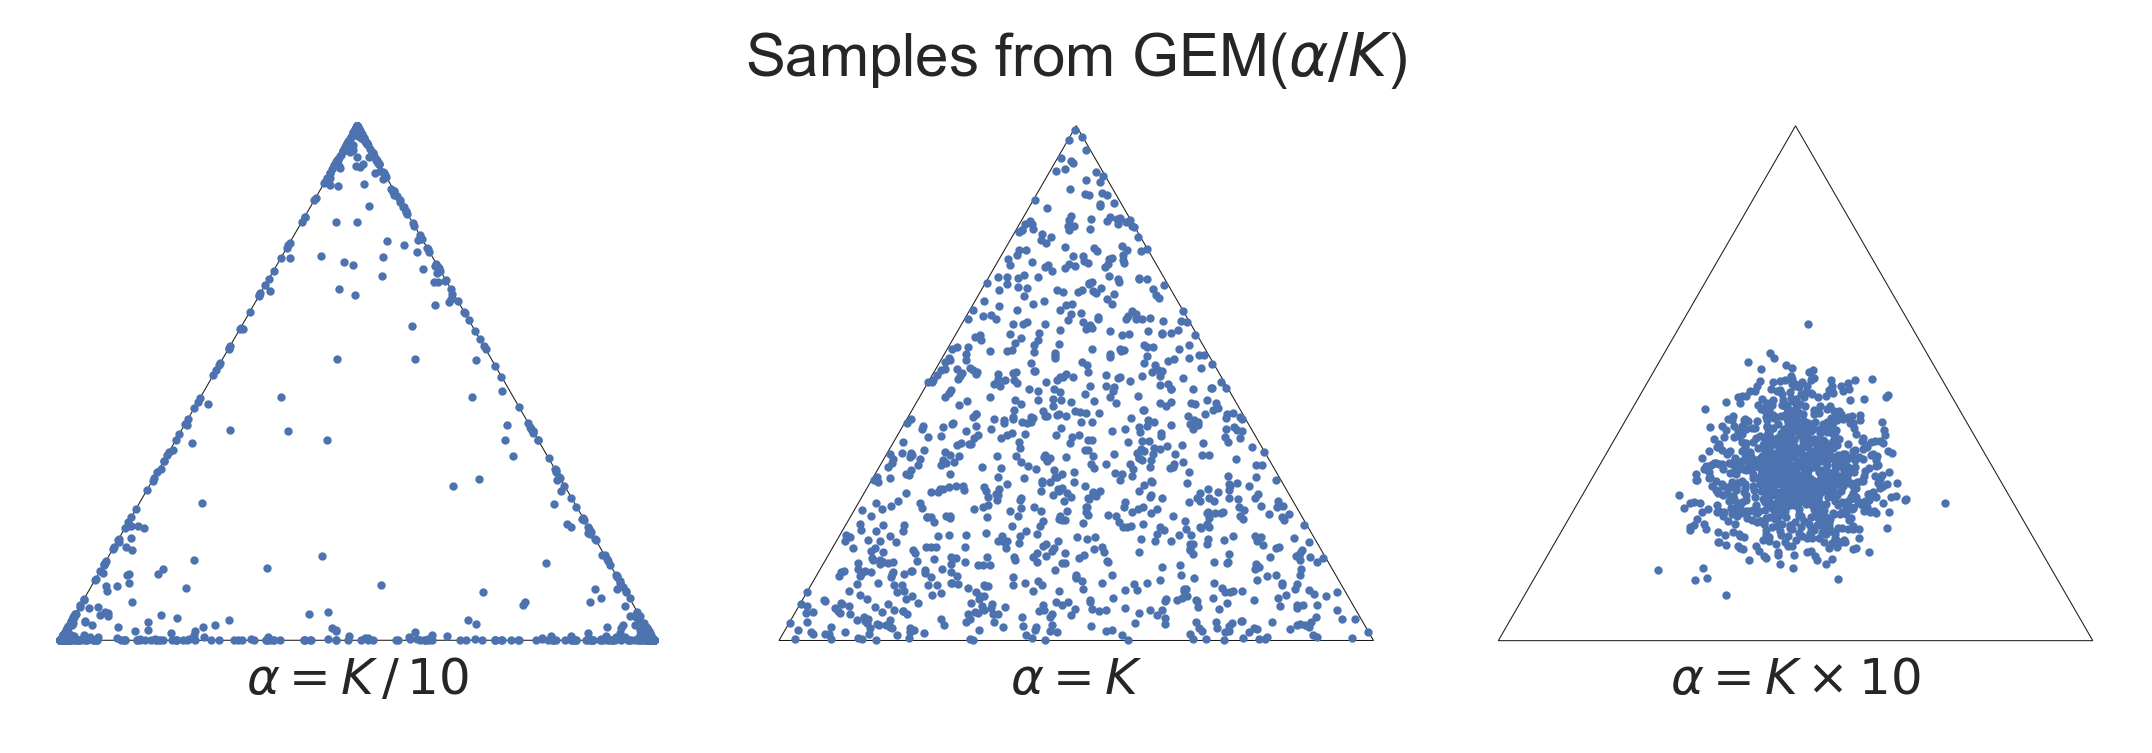

In [5]:

K = 3

def plt_samples(alpha, ax, *, num_samples=1000):
    
    samples = dirichlet(alpha * np.ones(K) / K).rvs(size=num_samples)
    xypts = np.array([bc2xy(s) for s in samples])

    ax.add_patch(
        mpl.patches.Polygon(
            corners,
            closed=True,
            fill=False,
            lw=0.25,
            color='k'
        )
    )
    ax.scatter(
        xypts[:, 0],
        xypts[:, 1],
        s=1.0**2,
        zorder=2
    )
    ax.axis('equal')
    ax.axis("off")

fig, (ax1, ax2, ax3) = plt.subplots(
    1,
    3,
    figsize=(9, 3),
    dpi=300,
    gridspec_kw=dict(wspace=0.1)
)

plt_samples(K / 10.0, ax1)
ax1.text(0.5, -0.09, r"$\alpha = K\,/\,10$", ha="center", size="medium")

plt_samples(K, ax2)
ax2.text(0.5, -0.09, r"$\alpha = K$", ha="center", size="medium")

plt_samples(K * 10.0, ax3)
ax3.text(0.5, -0.09, r"$\alpha = K \times 10$", ha="center", size="medium")

plt.savefig("fig_gem_samples.pdf", pad_inches=0, bbox_inches='tight')
ax2.text(0.5, 0.95, r"Samples from GEM($\alpha / K$)", ha="center", size="large")
plt.show()
